In [93]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras import backend as K
from keras.losses import *
from keras.datasets import mnist
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

# VAE Example in Keras

## VariationalAutoEncoder

In [112]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [130]:
class VAE():
    """
        Variational Auto Encoder used for data generation and latent data representation
        Model is a simple MLP
        adapted from https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self):
        
        self.encoder = None
        self.decoder = None
        self.vae = None
        self.z_mean = None
        self.z_log_var = None
        self.z = None
        self.loss = None

    def initialize(self,X):
        # network parameters
        original_dim = X.shape[-1]
        input_shape = (original_dim, )
        intermediate_dim = 512
        batch_size = 128
        latent_dim = 2
        epochs = 50

        # VAE model = encoder + decoder
        # build encoder model
        
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(intermediate_dim, activation='relu')(inputs)
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
        def sample(args):
            """ reparameterization trick
                z ~ N(mu,sigma^2*I) -> z = mu + sigma*e where e ~ N(0,I)
            """
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(z_log_var/2) * epsilon

        z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

        # encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        self.encoder.summary()

        # build decoder model
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        self.decoder.summary()
        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

        reconstruction_loss = binary_crossentropy(inputs,
                                                      outputs)
        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')
    
    def mean_squared_error(self,y_true, y_pred):
        return K.mean(K.square(y_pred - y_true), axis=-1)
        
    def fit(self,X_train,X_test,batch_size=1,epochs=30):
        self.vae.fit(X_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test,None))
        
    def predict(self,X):
        return self.vae.predict(X)



In [131]:
vae = VAE()
vae.initialize(x_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_158 (Dense)               (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_158[0][0]                  
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_158[0][0]                  
__________________________________________________________________________________________________
z (Lambda)

/home/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:78: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


In [132]:
vae.fit(x_train,x_test,batch_size=64,epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 97s 2ms/step - loss: 183.6845 - val_loss: 168.8395
Epoch 2/10
60000/60000 [==============================] - 92s 2ms/step - loss: 166.3601 - val_loss: 164.4634
Epoch 3/10
60000/60000 [==============================] - 86s 1ms/step - loss: 162.7449 - val_loss: 161.5454
Epoch 4/10
60000/60000 [==============================] - 87s 1ms/step - loss: 160.1363 - val_loss: 159.1065
Epoch 5/10
60000/60000 [==============================] - 88s 1ms/step - loss: 158.3446 - val_loss: 158.0838
Epoch 6/10
60000/60000 [==============================] - 87s 1ms/step - loss: 157.0700 - val_loss: 156.9909
Epoch 7/10
60000/60000 [==============================] - 88s 1ms/step - loss: 156.0931 - val_loss: 156.0840
Epoch 8/10
60000/60000 [==============================] - 88s 1ms/step - loss: 155.2829 - val_loss: 155.2769
Epoch 9/10
60000/60000 [==============================] - 87s 1ms/step - loss:

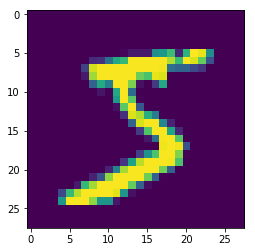

In [133]:
plt.imshow(x_train[0].reshape(28,28))

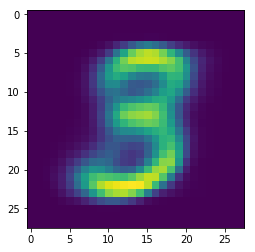

In [134]:
plt.imshow(vae.predict(x_train[0].reshape(1,784)).reshape(28,28))

In [135]:
def plot_results(encoder, decoder,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

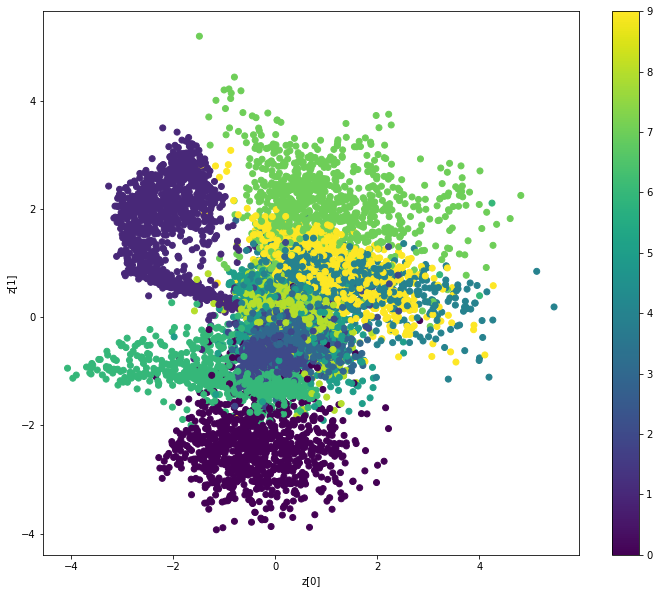

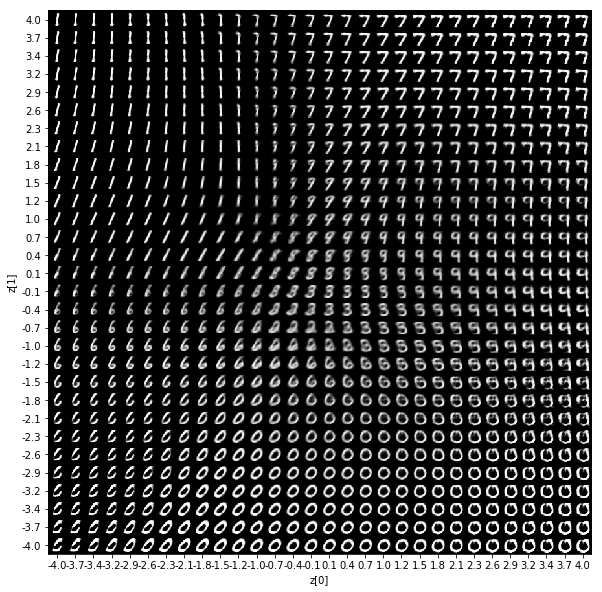

In [136]:
plot_results(vae.encoder,vae.decoder, data = (x_test, y_test))